<div>
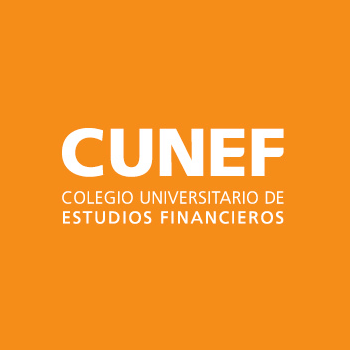
</div>

# **IBEX 35**

## *Librerías*



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV de los datos históricos del IBEX35 (^IBEX):

- Fuente: https://es.finance.yahoo.com/quote/%5EIBEX/history?period1=742435200&period2=1651968000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [2]:
df_ibex = pd.read_csv("^IBEX2.csv")
df_ibex['Date'] = pd.to_datetime(df_ibex['Date'])
df_ibex = df_ibex.set_index("Date")
df_ibex


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-07-12,2826.800049,2826.800049,2814.600098,2826.399902,2826.396973,0.0
1993-07-13,2826.399902,2843.699951,2820.899902,2843.399902,2843.396973,0.0
1993-07-14,2845.399902,2858.399902,2845.399902,2851.100098,2851.097168,0.0
1993-07-15,2848.699951,2848.699951,2835.000000,2843.699951,2843.697021,0.0
1993-07-16,2843.699951,2848.000000,2818.800049,2830.500000,2830.497070,0.0
...,...,...,...,...,...,...
2022-08-02,8060.600098,8122.500000,8049.799805,8096.899902,8096.899902,154636100.0
2022-08-03,8092.600098,8161.299805,8066.299805,8142.100098,8142.100098,146693600.0
2022-08-04,8148.000000,8214.400391,8133.899902,8161.100098,8161.100098,135699300.0


In [3]:
df_ibex = df_ibex.iloc[4273:,:]
df_ibex

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,11986.500000,12145.099609,11986.099609,12145.099609,12145.086914,184200.0
2010-01-05,12141.799805,12240.500000,12139.799805,12204.400391,12204.387695,238400.0
2010-01-06,12216.400391,12230.700195,12147.599609,12222.500000,12222.487305,123800.0
2010-01-07,12163.000000,12199.700195,12079.099609,12166.299805,12166.287109,192400.0
2010-01-08,12218.000000,12232.200195,12079.900391,12163.000000,12162.987305,213200.0
...,...,...,...,...,...,...
2022-08-02,8060.600098,8122.500000,8049.799805,8096.899902,8096.899902,154636100.0
2022-08-03,8092.600098,8161.299805,8066.299805,8142.100098,8142.100098,146693600.0
2022-08-04,8148.000000,8214.400391,8133.899902,8161.100098,8161.100098,135699300.0


Los datos bursátiles que tenemos están a diario. Podríamos descargar el CSV con dichos datos de manera mensual, pero optaremos por hacer una conversión usando la función de remuestreo (resample) que ofrece la librería Pandas.
- Fuente de información: https://stackoverflow.com/questions/28126286/convert-daily-pandas-stock-data-to-monthly-data-using-first-trade-day-of-the-mon

In [4]:
type(df_ibex) #comprobamos que en efecto es un DataFrame

pandas.core.frame.DataFrame

In [5]:
ohlc_dict = {'Open':'first',
             'High':'max',
             'Low':'min',
             'Close': 'last',
             'Volume': 'sum'}
df_ibex = df_ibex.resample('MS', # Pondremos MS en vez de M para que se ubique a primeros de mes
                           closed='right', 
                           label='right').agg(ohlc_dict)
df_ibex

,Open,High,Low,Close,Volume
Date,,,,,
2010-02-01,11986.500000,12240.500000,10821.200195,10995.200195,4.525600e+06
2010-03-01,11022.400391,11201.599609,9916.599609,10434.900391,4.964200e+06
2010-04-01,10441.799805,11190.000000,10339.299805,11067.900391,4.147200e+06
2010-05-01,11143.200195,11566.099609,10077.900391,10492.200195,4.679000e+06
2010-06-01,10426.200195,10452.200195,8812.099609,9299.700195,7.588400e+06
...,...,...,...,...,...
2022-05-01,8536.099609,8877.700195,8344.900391,8584.200195,3.673824e+09
2022-06-01,8516.599609,8992.700195,8134.500000,8747.200195,4.377736e+09
2022-07-01,8778.900391,8881.599609,7994.200195,8176.100098,3.855604e+09



## *Graficación de la serie temporal y análisis*

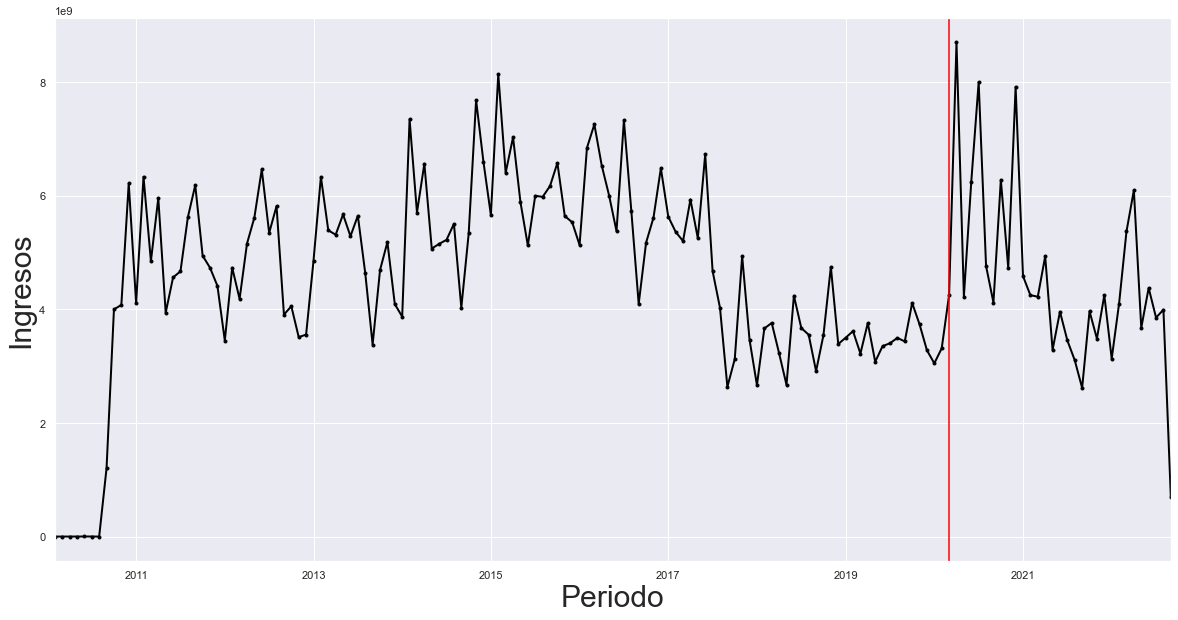

In [6]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_ibex['Volume'].plot(marker='.', color = 'black', linewidth= 2) 
fig.set_ylabel('Ingresos', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

No se aprecia una tendencia de los índices del IBEX pronunciada hacia ningún lado desde el inicio hasta
mediados del 2017, donde hay una tendencia decreciente. Sin embargo, desde el inicio de la época del COVID el IBEX presenta unos picos de subidas y bajadas muy pronunciados, derivados de decisiones políticas y sucesos que dependen de otras variables, como por ejemplo la vacunación.


A continuación, analizaremos mejor su estacionalidad y su tendencia mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

Ahora vamos a hacer el cálculo y la representación gráfica de la media y de la varianza:

In [7]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [8]:
mean = split_and_summarize(df_ibex, 'Volume', 4, np.mean)
variance = split_and_summarize(df_ibex, 'Volume', 4, np.var)

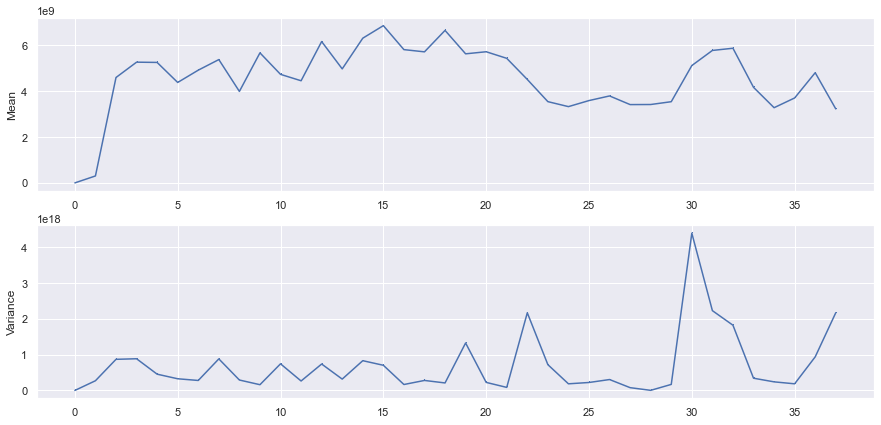

In [9]:
cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

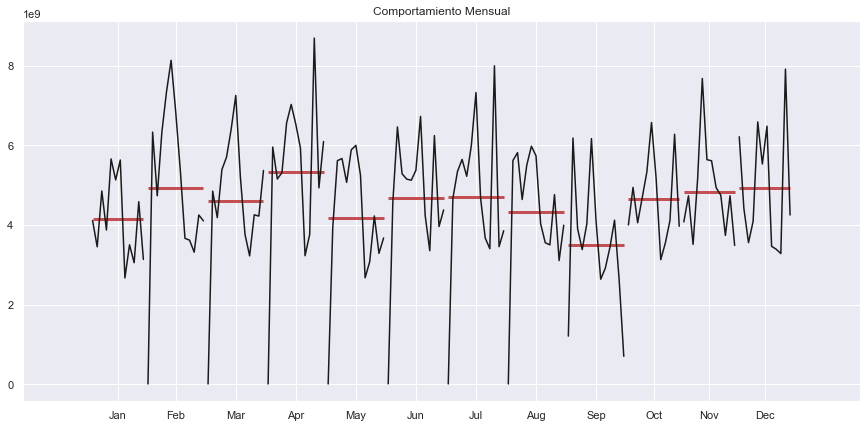

In [10]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_ibex['Volume'], ax=ax)
ax.set_title('Comportamiento Mensual');

Lo representamos también con box plots:

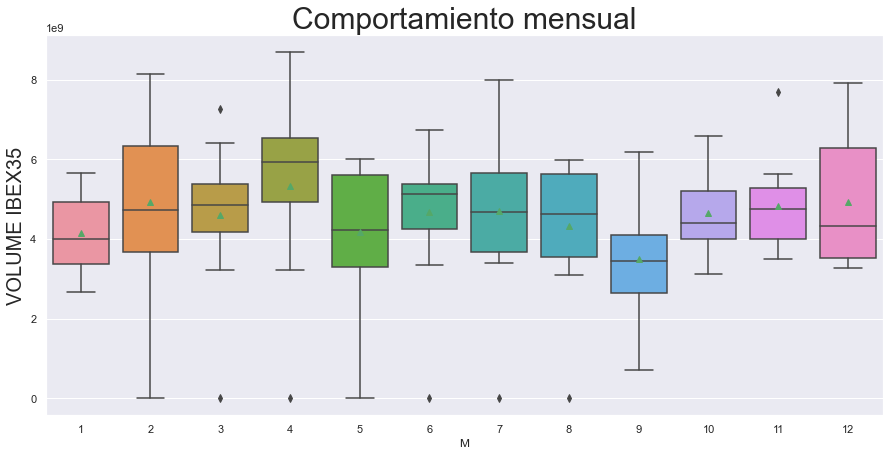

In [11]:
df_ibex['M'] = df_ibex.index.month
sns.boxplot(data = df_ibex, x = 'M', y='Volume', showmeans=True)
ax = plt.gca()
ax.set_ylabel('VOLUME IBEX35', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);


Por último, el desglose de la estacionalidad, de la tendencia y de los residuos para analizarlo:

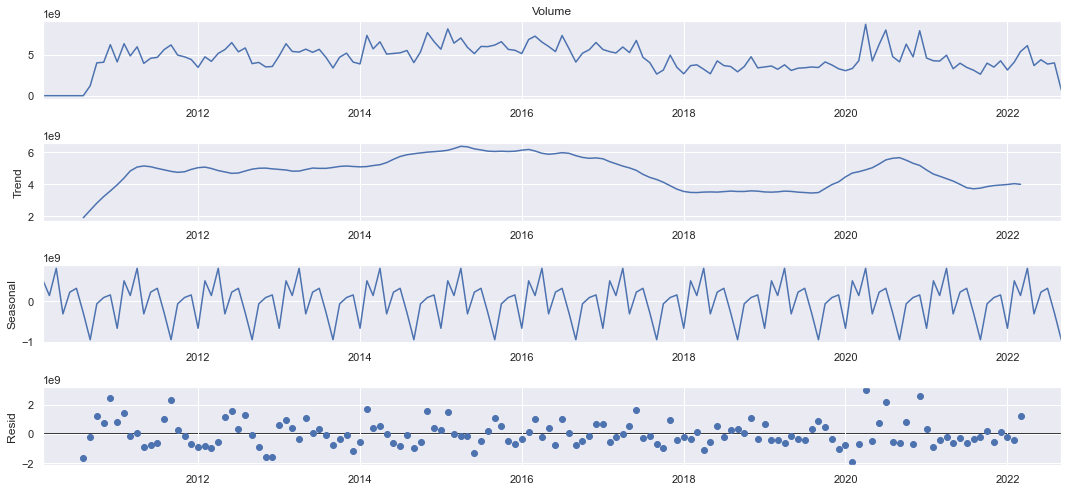

In [12]:
desglose = seasonal_decompose(df_ibex['Volume'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Como análisis, podemos concluir que:
- La tendencia no es muy clara, aunque se aprecia una tendencia decreciente en la época COVID.
- Hay una estacionalidad y se ve que aumenta más el precio del índice en el mes de marzo.
- Que la serie temporal no es estacionaria por tener unos valores de media y varianza bastante irregulares.

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.